Step 1: Imports

In [278]:
%%capture

!pip install nlp

In [280]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


Step 2: Fetch the data

In [281]:
%%capture

# Issue with dataset, so, downloading from a different source
# link to the thread: https://github.com/dair-ai/emotion_dataset/issues/5
# Dataset details are present here: https://huggingface.co/datasets/dair-ai/emotion

!pip install datasets
from datasets import load_dataset

dataset = load_dataset('emotion')

In [282]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [283]:
train = dataset['train']

tweets = train['text']
labels = train['label']

print(tweets[:5])
print(labels[:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']
[0, 0, 3, 2, 3]


In [284]:
# from the dataset, https://huggingface.co/datasets/dair-ai/emotion
# we know, 0: sadness, 1:joy, 2:love, 3:anger, 4:fear, 5:surprise

Step 3: Tokenizer

In [285]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [286]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [287]:
# testing the tokenizer

tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

Step 4: Padding and Truncating Sequences

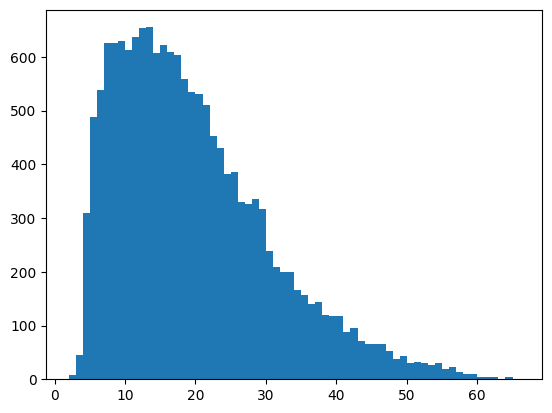

In [288]:
# Let's check the length of the tweets

lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [289]:
# For our model to run, we need to have same length for all the sequences

maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [290]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post',maxlen=maxlen)
    return padded

In [291]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [292]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Step 5: Labels

In [293]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


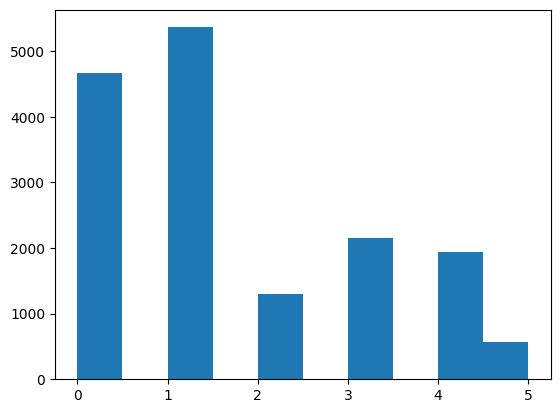

In [294]:
plt.hist(labels)
plt.show()

In [295]:
# Class imbalance problem above, since some have a lot of examples, while others have comparitively less
# Not solving this in the current notebook

In [296]:
index_to_class = {0: 'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
class_to_index = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

Step 6: Create the model

In [297]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']  
)

In [298]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 50, 40)           5920      
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


Step 7: Train the model

In [299]:
# Let's prepare the validation set

val = dataset['validation']

val_tweets = val['text']
val_labels = val['label']

val_seq = get_sequences(tokenizer, val_tweets)

In [300]:
train_labels = np.array(labels)
val_labels = np.array(val_labels)

h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 12s 17ms/step - loss: 1.2650 - accuracy: 0.5026 - val_loss: 0.7924 - val_accuracy: 0.7260
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.5340 - accuracy: 0.8192 - val_loss: 0.5696 - val_accuracy: 0.8125
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3467 - accuracy: 0.8843 - val_loss: 0.5195 - val_accuracy: 0.8365
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2545 - accuracy: 0.9178 - val_loss: 0.4473 - val_accuracy: 0.8620
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1952 - accuracy: 0.9381 - val_loss: 0.4356 - val_accuracy: 0.8680
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1487 - accuracy: 0.9538 - val_loss: 0.4552 - val_accuracy: 0.8755
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1221 - accuracy: 0.9613 - val_loss: 0.5226 - val_accuracy: 0.871

Step 8: Evaluate the model

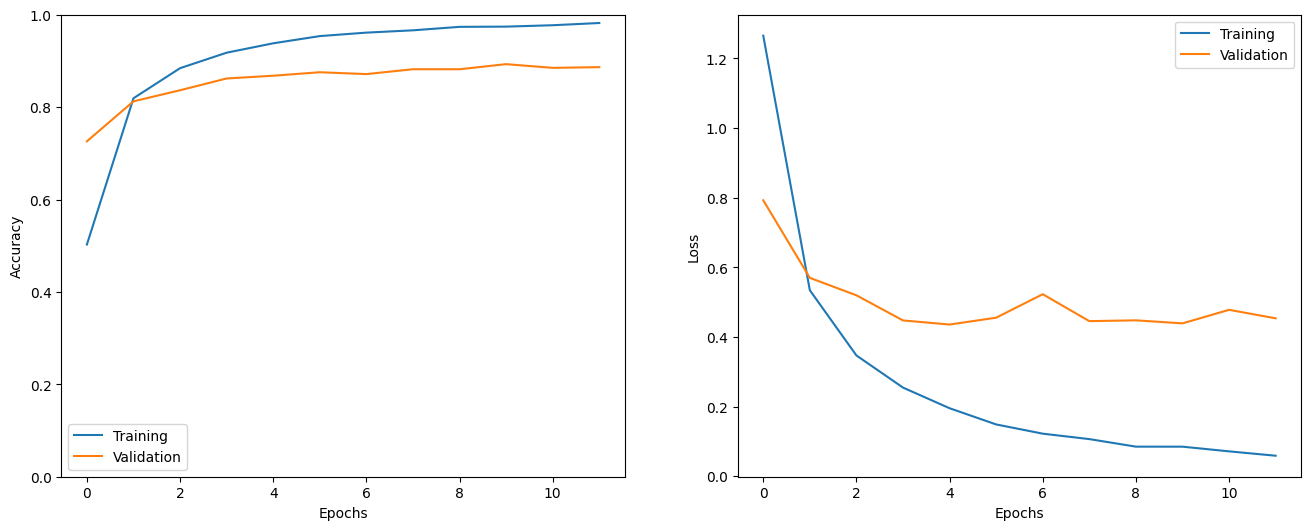

In [301]:
# Let's visualise the training history

show_history(h)

In [302]:
# Prepare the test set

test = dataset['test']

test_tweets = test['text']
test_labels = test['label']

test_seq = get_sequences(tokenizer, test_tweets)
test_labels = np.array(test_labels)

In [303]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 4ms/step - loss: 0.4212 - accuracy: 0.8790


In [304]:
# Let's check at individual predictions on the test set

i = random.randint(0, len(test_labels) - 1)

print(test_tweets[i])
print(test_labels[i])
print(index_to_class[test_labels[i]])

pred = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(pred).astype('uint8')]
print(pred_class)

i want to get back in the habit of blogging about all the cool fun things im up to but am also trying to get out of this rut of only writing about feeling shitty
0
sadness
1/1 [==============================] - 1s 627ms/step
sadness


63/63 [==============================] - 0s 4ms/step


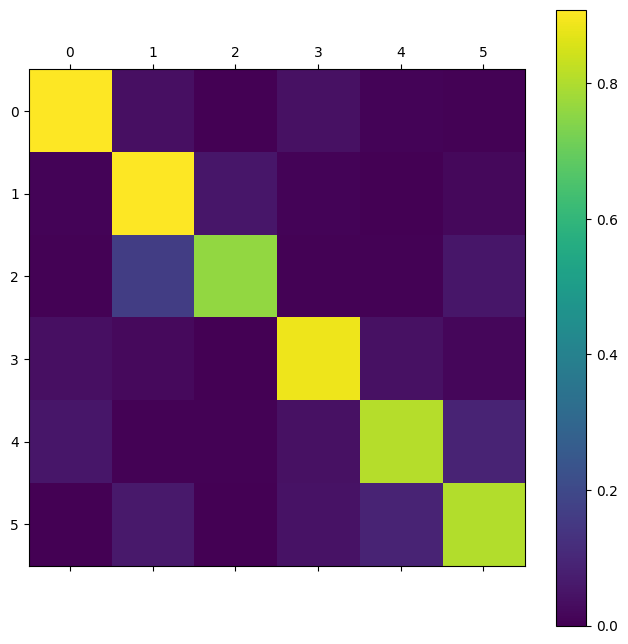

In [305]:
# Let's have all the predictions on the test set

all_preds = model.predict(test_seq)
pred_classes=np.argmax(all_preds,axis=1)


show_confusion_matrix(test_labels, pred_classes, list(classes))

Step 9: Let's evaluate on any random data given by user

In [312]:
# Add a list of tweets to be tested in the user_input_tweets below
# Note: It might not be very accurate, so just for fun

user_input_tweets = ['I am feeling uncomfortable going outside today']

# Padding and truncating with the tokenizer
tweets_seq = get_sequences(tokenizer, user_input_tweets)

# Predict using the model
emotion_pred = model.predict(tweets_seq)
emotion_int = np.argmax(emotion_pred,axis=1).astype('uint8')
emotion = [index_to_class[emo] for emo in emotion_int]
emotion

1/1 [==============================] - 0s 75ms/step


['fear']